# Предсказание коэффициента восстановления золота из золотосодержащей руды


In [1]:
import pandas as pd
import pandas_profiling
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import IPython
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

### 1.2 Проверим правильно ли рассчитана эффективность обогащения 

In [3]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

Recovery_final
- С = 'final.output.concentrate_au'
- F = 'rougher.output.concentrate_au'
- T = 'final.output.tail_au'


Recovery_rougher
- C = 'rougher.output.concentrate_au'
- F = 'rougher.input.feed_au'
- T = 'rougher.output.tail_au'

In [5]:
def recovery_rougher(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    R = (C*(F-T))/(F*(C-T))*100
    
  
    return R

In [6]:
# рассчитаем Recovery для этапа флотация и добавим столбец в датафрейм
train['recovery_rougher_au'] = train.apply(recovery_rougher,axis=1)

In [7]:
#найдем MAE между нашими расчетами и значениями признака
mae = mean_absolute_error(train['rougher.output.recovery'],train['recovery_rougher_au'])
display('Среднее абсолютное отклонение = {:.17f}'.format(mae))

'Среднее абсолютное отклонение = 0.00000000000000974'

In [8]:
train = train.drop(['recovery_rougher_au'], axis=1) #удалим ненужный столбец

### Вывод:
Среднее абсолютное отклонение стремится к 0. 
Наши расчеты совпадают со значениями признака rougher.output.recovery. Соответственно эффективность обогащения рассчитана правильно.  

## 1.3 Проанализируем признаки, недоступные в тестовой выборке

In [9]:
tag = []
for title in train.columns:
    if title not in test.columns:
        tag.append(title)
print(tag)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

In [10]:
print(len(train.columns))
print(len(test.columns))
print(len(tag))

87
53
34


### Вывод:
В test отсутсвует 34 параметра, из них 2 - это target: 'final.output.recovery' и 'rougher.output.recovery'.
В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса:
- final_output.concentrate_xx - финальные характеристики параметра продукта (концентрация_xx) - 4 шт.
- final.output.tail_xx - финальные характеристики параметра продукта в отвальном хвосте (концентрация_xx) - 4 шт.
- primary_cleaner.output.concentrate_xx - параметр продукта после первичной очистки (концентрация_xx) - 4 шт.
- primary_cleaner.output.tail_xx - параметр продукта в отвальном хвосте после первичной очистки (концентрация_xx) - 4 шт.
- rougher.calculation.sulfate_to_au_concentrate - расчет сульфата для флотации золота - 1 шт.
- rougher.calculation.floatbankxx_sulfate_to_au_feed - расчет сульфата для флотации золота на флотационную установку_xx - 2 шт. 
- rougher.calculation.au_pb_ratio - расчет соотношения золота и свинца после флотации - 1 шт. 
- rougher.output.concentrate_xx - параметр продукта после флотации(концентрат_xx) - 4 шт.
- rougher.output.tail_xx - параметр продукта в отвальном хвосте после флотации (концентрат_xx) - 4 шт.
- secondary_cleaner.output.tail_xx - параметр продукта в отвальном хвосте после вторичной очистки (концентрация_xx) - 4 шт.  



### 1.4 Предобработка данных

In [11]:
train.shape

(14149, 87)

In [12]:
test.shape

(5290, 53)

In [13]:
full.shape

(19439, 87)

In [14]:
print(train.duplicated().sum()) 
print(test.duplicated().sum()) 
print(full.duplicated().sum()) 

0
0
0


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [16]:
# проверка на наличие пропусков 
train.isna().sum().sort_values(ascending=False).head(20)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
primary_cleaner.output.concentrate_pb         86
rougher.input.feed_sol                        78
primary_cleaner.output.tail_sol               46
rougher.input.floatbank11_sulfate             36
primary_cleaner.input.depressant              32
rougher.input.floatbank10_sulfate             29
rougher.output.concentrate_sol                22
secondary_cleaner.state.floatbank2_b_air      21
primary_cleaner.input.sulfate                 20
primary_cleaner.output.tail_pb                15
dtype: int64

In [17]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [18]:
# посмотрим на матрицу корреляций, чтобы убедиться, что нет линейных зависимостей 
corr_mat = round(train.corr(),2)
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
corr_mat

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,0.00,0.02,0.35,-0.10,0.13,0.29,-0.10,0.05,0.19,0.02,...,0.04,0.17,0.02,0.01,0.01,0.23,0.02,0.20,0.17,0.06
final.output.concentrate_pb,0.02,0.00,-0.01,0.32,0.09,-0.10,0.24,0.07,0.03,0.12,...,-0.00,-0.04,0.09,0.07,0.10,-0.10,0.12,-0.12,-0.02,0.08
final.output.concentrate_sol,0.35,-0.01,0.00,0.22,0.25,0.23,0.26,-0.02,0.24,0.34,...,-0.01,0.27,0.03,0.13,0.03,0.25,0.02,0.23,0.23,-0.28
final.output.concentrate_au,-0.10,0.32,0.22,0.00,0.25,0.08,0.07,0.10,-0.07,0.11,...,0.04,-0.04,0.00,-0.01,0.01,-0.10,-0.01,-0.09,-0.12,-0.03
final.output.recovery,0.13,0.09,0.25,0.25,0.00,0.15,-0.15,-0.09,-0.44,0.40,...,0.21,0.06,0.17,-0.09,0.10,0.02,0.07,0.04,-0.03,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,0.23,-0.10,0.25,-0.10,0.02,-0.01,0.07,-0.09,0.12,-0.03,...,0.11,0.79,0.01,0.55,0.08,0.00,0.04,0.88,0.51,0.38
secondary_cleaner.state.floatbank5_b_air,0.02,0.12,0.02,-0.01,0.07,0.01,0.22,-0.13,-0.10,-0.00,...,0.72,0.24,0.88,0.15,0.89,0.04,0.00,0.05,0.47,-0.03
secondary_cleaner.state.floatbank5_b_level,0.20,-0.12,0.23,-0.09,0.04,-0.00,0.08,-0.10,0.10,-0.02,...,0.11,0.75,0.04,0.52,0.10,0.88,0.05,0.00,0.49,0.34
secondary_cleaner.state.floatbank6_a_air,0.17,-0.02,0.23,-0.12,-0.03,-0.10,0.07,0.00,0.07,-0.11,...,0.21,0.57,0.31,0.27,0.44,0.51,0.47,0.49,0.00,0.10


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [20]:
# проверка на наличие пропусков 
test.isna().sum().sort_values(ascending=False).head(20)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
dtype: int64

In [21]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [22]:
# посмотрим на матрицу корреляций, чтобы убедиться, что нет линейных зависимостей 
corr_mat = round(test.corr(),2)
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
corr_mat

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,0.00,0.46,0.11,0.50,0.10,0.05,0.08,0.14,0.02,0.03,...,0.31,0.12,0.35,0.07,0.09,0.13,0.16,0.07,-0.13,0.03
primary_cleaner.input.depressant,0.46,0.00,0.22,0.15,0.14,0.24,0.15,0.20,0.04,0.21,...,0.33,0.12,0.24,-0.09,-0.09,0.01,0.06,0.00,-0.20,0.03
primary_cleaner.input.feed_size,0.11,0.22,0.00,-0.29,-0.06,0.08,-0.06,0.07,-0.09,0.07,...,-0.15,-0.12,-0.17,-0.14,-0.19,-0.06,-0.21,-0.05,0.03,-0.08
primary_cleaner.input.xanthate,0.50,0.15,-0.29,0.00,0.21,-0.06,0.15,0.02,0.04,-0.08,...,0.31,0.13,0.36,0.12,0.06,0.13,0.08,0.10,-0.22,0.08
primary_cleaner.state.floatbank8_a_air,0.10,0.14,-0.06,0.21,0.00,0.12,0.97,-0.02,0.81,0.11,...,0.47,0.01,0.48,-0.06,0.41,0.27,0.47,0.16,0.35,0.17
primary_cleaner.state.floatbank8_a_level,0.05,0.24,0.08,-0.06,0.12,0.00,0.10,0.42,-0.02,0.78,...,0.17,0.10,0.08,-0.01,-0.04,0.16,-0.01,0.09,-0.11,0.08
primary_cleaner.state.floatbank8_b_air,0.08,0.15,-0.06,0.15,0.97,0.10,0.00,0.01,0.86,0.10,...,0.48,0.02,0.49,-0.08,0.42,0.26,0.50,0.16,0.39,0.19
primary_cleaner.state.floatbank8_b_level,0.14,0.20,0.07,0.02,-0.02,0.42,0.01,0.00,-0.03,0.41,...,0.08,0.22,0.05,-0.04,-0.01,0.03,0.01,0.00,-0.01,0.01
primary_cleaner.state.floatbank8_c_air,0.02,0.04,-0.09,0.04,0.81,-0.02,0.86,-0.03,0.00,0.00,...,0.37,0.05,0.40,-0.03,0.40,0.24,0.50,0.12,0.49,0.17
primary_cleaner.state.floatbank8_c_level,0.03,0.21,0.07,-0.08,0.11,0.78,0.10,0.41,0.00,0.00,...,0.15,0.09,0.07,-0.01,-0.02,0.14,-0.00,0.06,-0.09,0.07


In [23]:
full.isna().sum().sort_values(ascending=False).head(20)

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
final.output.concentrate_sol                 211
rougher.input.feed_size                      145
primary_cleaner.output.concentrate_pb        116
primary_cleaner.input.xanthate               104
final.output.tail_pb                         101
rougher.input.feed_pb                        100
rougher.input.feed_sol                        99
primary_cleaner.output.tail_sol               62
rougher.input.floatbank11_sulfate             44
primary_cleaner.input.depressant              37
rougher.input.floatbank10_sulfate             34
primary_cleaner.input.sulfate                 24
rougher.output.concentrate_sol                23
secondary_cleaner.state.floatbank2_b_air      23
primary_cleaner.output.tail_pb                21
dtype: int64

- Необходимоп поменять ип данных в столбце 'date'
- удалить пропуски в столбцах rougher.output.recovery и final.output.recovery
- пропуски в остальных столбцах заполнить
- отсутствующие столбцы с признаками в тестовой выборке подтянуть с full. 
- также в обучающей и тестовой выборках разное кол-во столбцов, удалим из обучающей те, которые отсутствуют в тестовой. 

In [24]:
# изменим тип данных в столбце 'date' во всех выборках
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%dT%H:%M:%S')
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%dT%H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%dT%H:%M:%S')

In [25]:
# удалим пропущенные значения в выборках
full = full.dropna(subset=['rougher.output.recovery', 'final.output.recovery']) 
train = train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

In [26]:
# заполним пропущенные значения в выборках
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full = full.fillna(method='ffill')

In [27]:
# добавим недостающие столбцы в тестовую выборку
test = test.join(full['rougher.output.recovery'])
test = test.join(full['final.output.recovery'])

In [28]:
# удалим из обучающей выборки столбцы, которые отсутсвуют в тестовой
col = []
for title in train.columns:
    if title not in test.columns:
        col.append(title)
train = train.drop(columns=col)

In [29]:
train.shape

(14149, 55)

In [30]:
test.shape

(5290, 55)

In [31]:
# проверим соответствия столбцов train и test
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

list(set(train_cols) - set(test_cols)), list(set(test_cols) - set(train_cols))

([], [])

Теперь в выборках одинаковое кол-во столбцов

# 2.0 Анализ данных

 ## 2.1 Посмтрим как меняется концентрация металлов на различных этапах очистки

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [34]:
def concentration_of_metals(metal, title):
    x0 = full[f'rougher.input.feed_{metal}']
    x1 = full[f'rougher.output.concentrate_{metal}']
    x2 = full[f'primary_cleaner.output.concentrate_{metal}']
    x3 = full[f'final.output.concentrate_{metal}']

    plt.figure(figsize=(12, 6))

    sns.kdeplot(x0, fill=True, common_norm=False, alpha=0.4, label='Сырье')
    sns.kdeplot(x1, fill=True, common_norm=False, alpha=0.4, label='Черновой')
    sns.kdeplot(x2, fill=True, common_norm=False, alpha=0.4, label='Первичная очистка')
    sns.kdeplot(x3, fill=True, common_norm=False, alpha=0.4, label='Финальный этап')

    plt.title(label=f'Концентрация {title} на различных этапах очистки', fontsize=15)
    plt.xlabel('Концентрация')
    plt.legend()


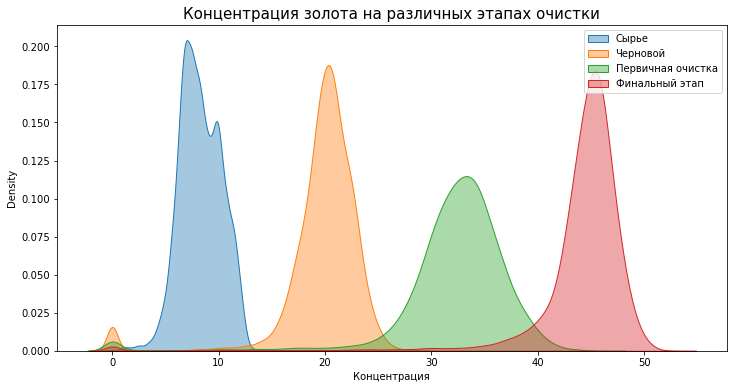

In [35]:
concentration_of_metals('au', 'золота')

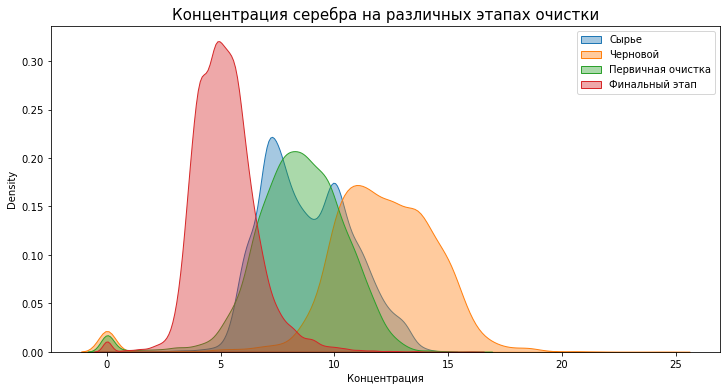

In [36]:
concentration_of_metals('ag', 'серебра')

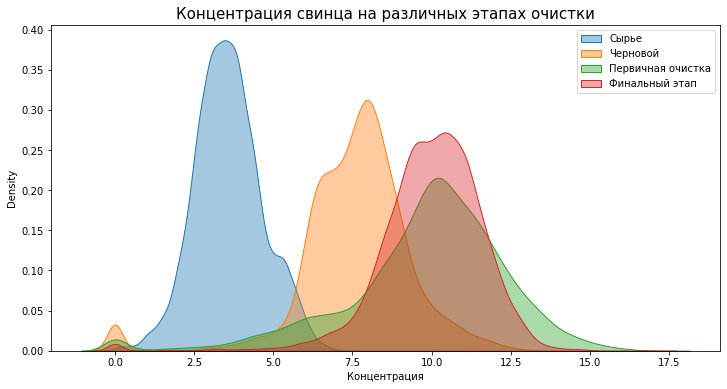

In [37]:
concentration_of_metals('pb', 'свинца')

### Вывод:
- Концентрация золота увеличивается после каждого этапа очистки. 
- Концентрация серебра увеличивается после флотации, но уменьшается после последующих очисток. 
- Концентрация свинца увеличивается после каждой очистки.  

## 2.2 Сравнение распределения гранул сырья на обучающей и тестовой выборках. 

In [38]:
def feed_size(step, title):
    x0 = train[f'{step}.input.feed_size']
    x1 = test[f'{step}.input.feed_size']
    plt.figure(figsize=(12, 6))
    sns.kdeplot(x0, fill=True, common_norm=False, alpha=0.4, label='Train')
    sns.kdeplot(x1, fill=True, common_norm=False, alpha=0.4, label='Test')
    plt.xlabel('Размер гранул')
    plt.legend()
    plt.title(label=f'Распределение размеров гранул сырья для {title}', fontsize=15)

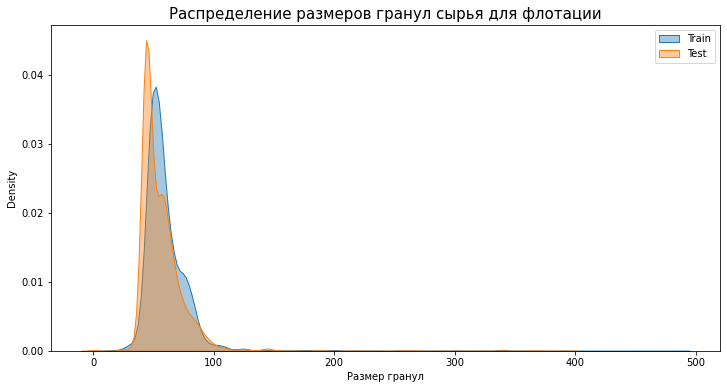

In [39]:
feed_size('rougher', 'флотации')

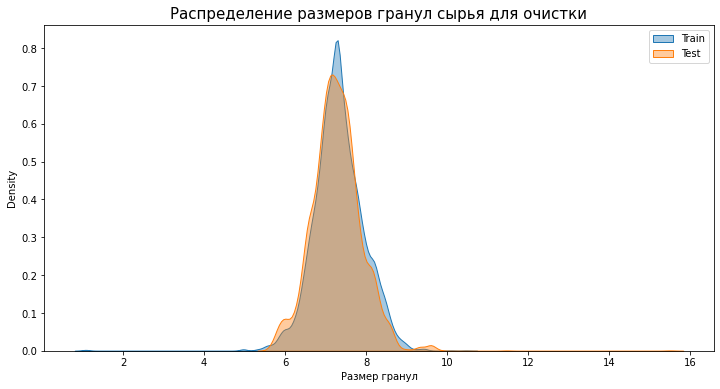

In [40]:
feed_size('primary_cleaner', 'очистки')

### Вывод:
Распределение размеров гранул сырья на обучающей и тестовой выборках схожи.

## 2.3 Исследование суммарной концентрации всех веществ на разных стадиях

In [41]:
metals = ['au', 'ag', 'pb', 'sol']
steps = ['rougher.input.feed_',
         'rougher.output.concentrate_', 
         'final.output.concentrate_']
for step in steps:
    full[step] = full[step + metals[0]] + full[step + metals[1]] + full[step + metals[2]] + full[step + metals[3]]

Text(0.5, 1.0, 'Концентрация всех веществ на разных стадиях')

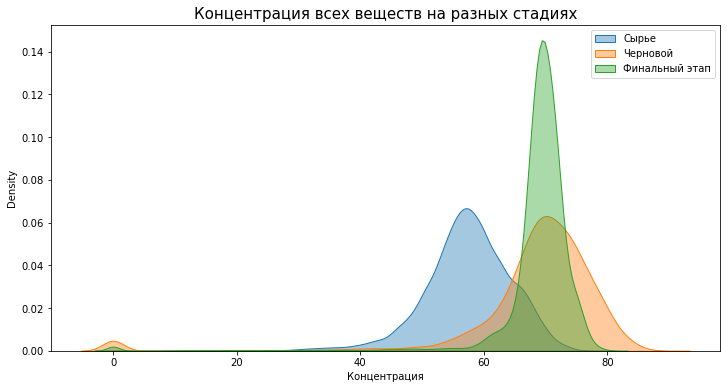

In [42]:
x0 = full['rougher.input.feed_']
x1 = full['rougher.output.concentrate_']
x2 = full['final.output.concentrate_']

plt.figure(figsize=(12, 6))

sns.kdeplot(x0, fill=True, common_norm=False, alpha=0.4, label='Сырье')
sns.kdeplot(x1, fill=True, common_norm=False, alpha=0.4, label='Черновой')
sns.kdeplot(x2, fill=True, common_norm=False, alpha=0.4, label='Финальный этап')


plt.xlabel('Концентрация')
plt.legend()
plt.title(label='Концентрация всех веществ на разных стадиях', fontsize=15)

### Вывод
После флотации и черновой стадии концентрация веществ увеличивается. Однако, график нам показал нулевые показатели, которые не являются нормой. Считаю нужным убрать строки с нулевыми данными.  

## 3. Построение модели 

In [43]:
# функция для вычисления итоговой sMAPE
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

In [44]:
# Для тестирования моделей кросс-валидацией необходимо создать собственный scorer, который будет высчитывать sMAPЕ.
smape_score = make_scorer(smape, greater_is_better=False)

In [45]:
# избавимся от лишних данных 
train = train.drop('date', axis=1).reset_index(drop=True)
test = test.drop('date', axis=1).reset_index(drop=True)

In [46]:
# избавимся от нулевых значений 
train = train[train != 0].dropna(axis=0)
test = test[test != 0].dropna(axis=0)

In [47]:
train.shape

(13769, 54)

In [48]:
test.shape

(5165, 54)

target - столбцы 'rougher.output.recovery' и 'final.output.recovery'
features - остальные столбцы выборки.

Разобьем и обучающую и тестовую выборки.

In [49]:
# объявим переменные features и target для каждой выборки
target_ind = ['rougher.output.recovery', 'final.output.recovery']

features_train_rougher = train.drop([('rougher.output.recovery'), ('final.output.recovery')], axis=1)
target_train_rougher = train['rougher.output.recovery']

features_train_final = train.drop([('rougher.output.recovery'), ('final.output.recovery')], axis=1)
target_train_final = train['final.output.recovery']


features_test_rougher = test.drop([('rougher.output.recovery'), ('final.output.recovery')], axis=1)
target_test_rougher = test['rougher.output.recovery']

features_test_final = test.drop([('rougher.output.recovery'), ('final.output.recovery')], axis=1)
target_test_final = test['final.output.recovery']



In [50]:
print(features_train_rougher.shape)
print(features_test_rougher.shape)

print(target_train_rougher.shape)
print(target_test_rougher.shape)

(13769, 52)
(5165, 52)
(13769,)
(5165,)


## Построение и обучение моделей

### Random Forest Regressor

In [51]:
%%time
model = RandomForestRegressor()
params = { 'n_estimators': range(10,15,1),
          'min_samples_leaf': range(1,6,2)}
model_rfr_r = RandomizedSearchCV(model, params, verbose=5, scoring=smape_score, cv=3, n_jobs=-1, random_state=12345)
model_rfr_r.fit(features_train_rougher, target_train_rougher) 
print(model_rfr_r.best_score_)
print(model_rfr_r.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-7.954702734316161
{'n_estimators': 13, 'min_samples_leaf': 3}
CPU times: user 5.38 s, sys: 185 ms, total: 5.56 s
Wall time: 25.6 s


In [52]:
%%time
model = RandomForestRegressor()
params = { 'n_estimators': range(10,15,1),
          'min_samples_leaf': range(1,6,2)}
model_rfr_f = RandomizedSearchCV(model, params, verbose=5, scoring=smape_score, cv=3, n_jobs=-1, random_state=12345)
model_rfr_f.fit(features_train_final, target_train_final) 
print(model_rfr_f.best_score_)
print(model_rfr_f.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-10.662633152619994
{'n_estimators': 13, 'min_samples_leaf': 5}
CPU times: user 5.81 s, sys: 34.1 ms, total: 5.85 s
Wall time: 24.8 s


In [53]:
mean_cvs_rfr = (model_rfr_f.best_score_ + model_rfr_r.best_score_)/2
print('Средний результат кросс валидации = ',mean_cvs_rfr)

Средний результат кросс валидации =  -9.308667943468077


### Linear Regression

In [54]:
%%time
model = LinearRegression()
params = { 'fit_intercept': ['True', 'False']}

model_lr_r = RandomizedSearchCV(model, params, verbose=5, scoring=smape_score, cv=3, n_jobs=-1)
model_lr_r.fit(features_train_rougher, target_train_rougher) 
print(model_lr_r.best_score_)
print(model_lr_r.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
-10.332388793438476
{'fit_intercept': 'True'}
CPU times: user 66.3 ms, sys: 31.3 ms, total: 97.5 ms
Wall time: 237 ms


In [55]:
%%time
model = LinearRegression()
params = { 'fit_intercept': ['True', 'False']}

model_lr_f = RandomizedSearchCV(model, params, verbose=5, scoring=smape_score, cv=3, n_jobs=-1)
model_lr_f.fit(features_train_final, target_train_final) 
print(model_lr_f.best_score_)
print(model_lr_f.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
-13.526174430197777
{'fit_intercept': 'True'}
CPU times: user 668 ms, sys: 295 ms, total: 963 ms
Wall time: 183 ms


In [56]:
mean_cvs_lr = (model_lr_f.best_score_ + model_lr_r.best_score_)/2
print('Средний результат кросс валидации = ',mean_cvs_lr)

Средний результат кросс валидации =  -11.929281611818126


### Decision Tree Regressor

In [57]:
%%time
model = DecisionTreeRegressor()
params = { 'max_depth': range (1,10, 2) }
model_dtr_r = RandomizedSearchCV(model, params, verbose=5, scoring=smape_score, cv=3, n_jobs=-1, random_state=12345)
model_dtr_r.fit(features_train_rougher, target_train_rougher) 
print(model_dtr_r.best_score_)
print(model_dtr_r.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
-8.229405173688937
{'max_depth': 3}
CPU times: user 368 ms, sys: 77.9 ms, total: 446 ms
Wall time: 911 ms


In [58]:
%%time
model = DecisionTreeRegressor()
params = { 'max_depth': range (1,10, 2) }
model_dtr_f = RandomizedSearchCV(model, params, verbose=5, scoring=smape_score, cv=3, n_jobs=-1, random_state=12345)
model_dtr_f.fit(features_train_final, target_train_final) 
print(model_dtr_f.best_score_)
print(model_dtr_f.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
-10.322762252040485
{'max_depth': 1}
CPU times: user 105 ms, sys: 7.43 ms, total: 112 ms
Wall time: 795 ms


In [59]:
mean_cvs_dtr = (model_dtr_f.best_score_ + model_dtr_r.best_score_)/2
print('Средний результат кросс валидации = ',mean_cvs_dtr)

Средний результат кросс валидации =  -9.276083712864711


In [60]:
df = pd.DataFrame({'name': ['RandomForest', 'linearRegression', 'DecisionTree'], 'mean_cvs': [-9.302, -11.929, -9.276]})
display(df)

,name,mean_cvs
0,RandomForest,-9.302
1,linearRegression,-11.929
2,DecisionTree,-9.276


Лучший показатель кросс валидации показала модель Decision Tree. Посчитаем sMAPE на тестовой выборке. 

In [61]:
pred_dtr_r = model_dtr_r.predict(features_test_rougher)
smape_dtr_r = smape(target_test_rougher, pred_dtr_r)

pred_dtr_f = model_dtr_f.predict(features_test_final)
smape_dtr_f = smape(target_test_final, pred_dtr_f)
smape_dtr_f, smape_dtr_r

(11.659087635112158, 9.684997825355634)

In [62]:
final_dtr_smape = 0.25*smape_dtr_r + 0.75*smape_dtr_f
print('sMAPE на тестовой выборке =', final_dtr_smape)

sMAPE на тестовой выборке = 11.165565182673028


### Проверка на адекватность

In [63]:
model_dr_r = DummyRegressor().fit(features_train_rougher, target_train_rougher)
pred_dr_r = model_dr_r.predict(features_test_rougher)
smape_dr_r = smape(target_test_rougher, pred_dr_r)

model_dr_f = DummyRegressor().fit(features_train_final, target_train_final)
pred_dr_f = model_dr_f.predict(features_test_final)
smape_dr_f = smape(target_test_final, pred_dr_f)
final_dr_smape = 0.25*smape_dr_r + 0.75*smape_dr_f

smape_dr_r, smape_dr_f
print('sMAPE на тестовой выборке =', final_dr_smape)

sMAPE на тестовой выборке = 9.611898604326829


# Вывод:
Целью данного проекта было подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 
Были обработаны пропущенные значения и удалены неизвестные таргеты с целью последующего построения моделей. Также были удалены строки с нулевыми значениями.  
Были замечены следующие закономерности:
- концентрация золота на всех этапах обогащения растет
- концентрация свинца также растет
- концетрация серебра падает.

Протестировано 3 модели - регрессия, случайный лес и дерево решений. Лучший результат кросс валидации показала модель Дерево Решений. 
На тестовой выборке данная модель показала значение sMAPE = 11.165
